# PROJET 07

---
## Réalisez une analyse de sentiments grâce au Deep Learning
### Nous allons ici tester différents modèles de prédiction de sentiment.

In [1]:
!pip install mlflow --quiet
!pip install pyngrok --quiet
!pip install plot_keras_history --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.3/26.3 MB 23.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 38.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.4/84.4 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 505.6/505.6 kB 20.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 202.9/202.9 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.5/61.5 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import time

# pre-traitement du text
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# pour le modèle simple
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score,roc_curve,f1_score,log_loss,recall_score

# pour le modèle LSTM

# Deep learning
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding,Conv1D, Bidirectional, LSTM, Dense, Input, Dropout,Flatten,GlobalAveragePooling1D
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping,ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from plot_keras_history import show_history, plot_history



# BERT
from transformers import AutoTokenizer, AutoModelForSequenceClassification,Trainer, TrainingArguments
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Suivi des métriques des modèles
import mlflow
from pyngrok import ngrok

from google.colab import drive
drive.mount('/content/drive')

pd.set_option('display.width', 1000)

Mounted at /content/drive


# Nettoyage, pre-processing

In [3]:
col = ["sentiment", "ids", "date", "flag", "user", "text"]

data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/PROJET07/training.1600000.processed.noemoticon.csv',encoding = 'latin1', names= col)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   sentiment  1600000 non-null  int64 
 1   ids        1600000 non-null  int64 
 2   date       1600000 non-null  object
 3   flag       1600000 non-null  object
 4   user       1600000 non-null  object
 5   text       1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


Le jeu de donnée étant très volumineux, nous n'en utiliserons qu'une partie pour limiter le temps d'entraînement des différents modèles

In [5]:
data = data.sample(30000).reset_index(drop=True)

On regarde si les classes sont équilibrées

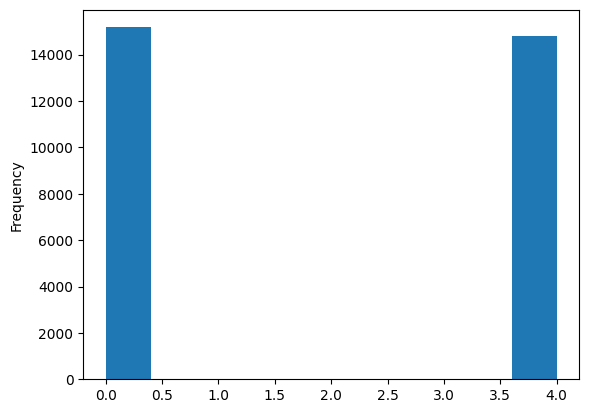

In [6]:
data['sentiment'].plot(kind ='hist')
plt.show()

Rappel des modalités pour le sentiment des tweets : **0 = negative, 4 = positive**

Nous remplacerons la modalité 4 par 1.

In [7]:
data['sentiment'] = data['sentiment'].replace(4,1)

In [8]:
data = data[['sentiment','text']]

In [9]:
data

,sentiment,text
0,1,@Tittch I'm tweeting via my phone We don't ha...
1,0,"@olofhellman - ugh, that sucks"
2,1,@pdurham see you later! have a brilliant morning
3,0,I was about 3 seconds away from burning the ho...
4,1,@SazFOB okay.i`ll check them out!
...,...,...
29995,1,@macrinaivazian I'm so happy for you! Can't wa...
29996,0,Pissed.! I hate this shit. I want this all too...
29997,0,@FenricWolf I don't have a USB to transmit it ...
29998,1,eating ham salad wraps and sourcream + oion ri...


In [10]:
# téléchargement des bases de caractères
nltk.download("stopwords")
nltk.download('punkt')
nltk.download('wordnet')
stop = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [11]:
# regex permettant d'ignorer les caractères spéciaux ainsi que les nombres et les mots contenant des underscores
def tokenize_column(text):
    tokenizer = nltk.RegexpTokenizer(r'\b(?![\w_]*_)[^\d\W]+\b')
    # Tokenisation de la description et suppression des majuscules
    tokens = tokenizer.tokenize(text.lower())

    return tokens

def lemmatize_word(text):

    lemmatizer = WordNetLemmatizer()
    lemma = [lemmatizer.lemmatize(token) for token in text]

    return lemma

def combine_text(list_of_text):

    combined_text = ' '.join(list_of_text)

    return combined_text


In [12]:
data['text_token'] =data['text'].apply(tokenize_column)
data['stopwords_removed'] = data['text_token'].apply(lambda x: [word for word in x if word not in stop])
data['lemmatize'] = data['stopwords_removed'].apply(lemmatize_word)

In [ ]:
print('Original :',"\n",data['text'][20],"\n")
print('Tokens :',"\n",data['text_token'][20],"\n")
print('Stopwords removed :',"\n",data['stopwords_removed'][20],"\n")
print('Lem :','\n',data['lemmatize'][20])

Original : 
 Its official. I'm sickies!  

Tokens : 
 ['its', 'official', 'i', 'm', 'sickies'] 

Stopwords removed : 
 ['official', 'sickies'] 

Lem : 
 ['official', 'sickies']


Déterminons le nombre de tokens par texte ainsi que son maximum


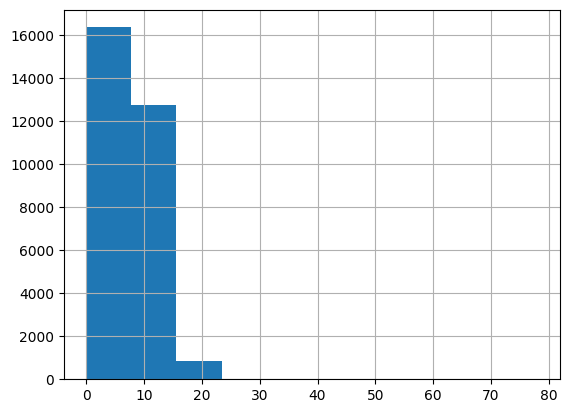

count    30000.000000
mean         7.523767
std          4.025723
min          0.000000
25%          4.000000
50%          7.000000
75%         10.000000
max         78.000000
dtype: float64

In [ ]:
text_len = [len(i) for i in data['lemmatize']]
pd.Series(text_len).hist()
plt.show()
pd.Series(text_len).describe()

In [13]:
max_lenght = data['lemmatize'].max()
max_lenght = data['lemmatize'].apply(lambda x : len(x)).max()

In [14]:
# version des documents pour BOW/TfIDF/W2V
data['text_combined'] = data['lemmatize'].apply(lambda x : combine_text(x))
# version des documents pour BERT (idem mais en conservant les stopwords)
data['text_dl'] = data['text_token'].apply(lambda x : combine_text(x))

# Fonctions

Nous définissons une fonction qui nous permettra de tracer la courbe ROC

In [15]:
def plotRocAuc(model, X, y):

    probabilities = model.predict_proba(X)
    probabilities = probabilities[:, 1]  # keep probabilities for first class only
    predict = model.predict(X)
    # Compute the ROC curve
    fpr, tpr, thresholds = roc_curve(y, probabilities)

    # Plot the "dumb model" line
    plt.plot([0, 1], [0, 1], linestyle='--')

    # Plot the model line
    plt.plot(fpr, tpr, marker='.')
    plt.text(0.75, 0.25, "AUC: " + str(round(roc_auc_score(y, probabilities),2)))
    plt.text(0.75, 0.3, "ACC: " + str(round(accuracy_score(y, predict),2)))
    plt.text(0.75, 0.34, "F1: " + str(round(f1_score(y, predict),2)))
    plt.text(0.75, 0.38, "recall: " + str(round(recall_score(y, predict),2)))
    plt.xlabel('Taux faux positifs')
    plt.ylabel('Taux vrai positifs')
    plt.title('ROC/ AUC pour %s' % (model))
    # show the plot
    plt.show()


In [16]:
# fonction pour les modèles Deep learning
def plotRocAuc2(model, X, y):

    predict = model.predict(X)
    # keep probabilities for first class only

    predict_binary = (predict > 0.5).astype(int)
    # Compute the ROC curve
    fpr, tpr, thresholds = roc_curve(y, predict)

    # Plot the "dumb model" line
    plt.plot([0, 1], [0, 1], linestyle='--')

    # Plot the model line
    plt.plot(fpr, tpr, marker='.')
    plt.text(0.75, 0.25, "AUC: " + str(round(roc_auc_score(y,predict),2)))
    plt.text(0.75, 0.3, "ACC: " + str(round(accuracy_score(y, predict_binary),2)))
    plt.text(0.75, 0.34, "F1: " + str(round(f1_score(y, predict_binary),2)))
    plt.text(0.75, 0.38, "recall: " + str(round(recall_score(y, predict_binary),2)))
    plt.xlabel('Taux faux positifs')
    plt.ylabel('Taux vrai positifs')
    plt.title('ROC/ AUC pour %s' % (model))
    # show the plot
    plt.show()

## Séparation du jeu de données | train - val - test

In [17]:
train_data, test_data = train_test_split(data, test_size=0.2, random_state=2)

train_data,val_data = train_test_split(train_data, test_size=0.2, random_state=2)

In [18]:
y_train= train_data['sentiment'].values
y_val= val_data['sentiment'].values
y_test= test_data['sentiment'].values

# Classification Machine Learning : Regression Logistique

Nous allons vectoriser nos différents textes à l'aide de la méthode TF-IDF afin d'avoir des données d'entrée interprétables pour notre modèle

In [19]:
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(train_data['text_combined'])
X_test_tfidf = vectorizer.transform(test_data['text_combined'])

tfidf_features = vectorizer.get_feature_names_out()
print( 'Taille du vocabulaire : '+str(len(tfidf_features)))

Taille du vocabulaire : 24565


temps traitement :  0.0


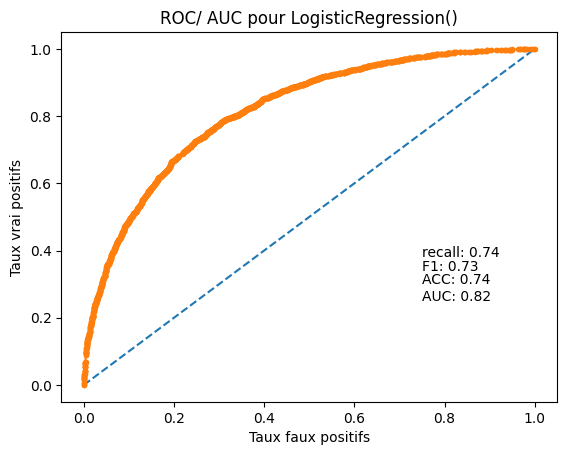

In [20]:
model_lr = LogisticRegression()
# Entraînement du modèle

time1 = time.time()
model_lr.fit(X_train_tfidf, y_train)
time2 = np.round(time.time() - time1,0)
print("temps traitement : ", time2)
# Prédiction sur les données de test
y_pred = model_lr.predict(X_test_tfidf)
# Evaluation du modèle
plotRocAuc(model_lr, X_test_tfidf, y_test)

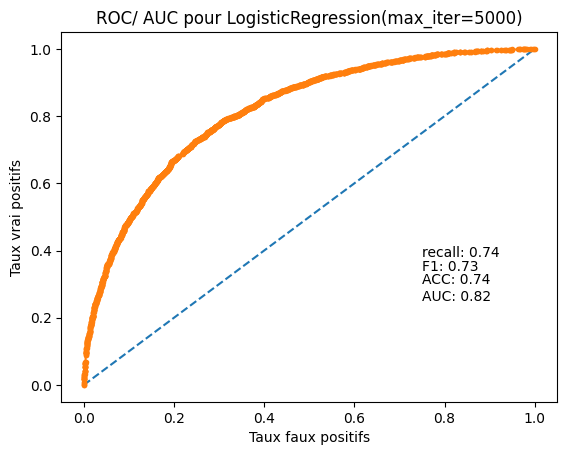

In [21]:
model_lr2 = LogisticRegression(max_iter=5000)

# Entraînement du modèle
model_lr2.fit(X_train_tfidf, y_train)
# Prédiction sur les données de test
y_pred = model_lr2.predict(X_test_tfidf)
# Evaluation du modèle
plotRocAuc(model_lr2, X_test_tfidf, y_test)

# Modèle avancé

## LSTM | embedding keras
Dans ce premiere modèle nous réaliserons l'embedding entraîné sur notre corpus. Pas de tranfer learning donc.

**Tokenisation, padding**

---

On détermine la taille de la plus grande séquence

In [22]:
# Tokenizer Keras
tokenizer_lstm = Tokenizer()

tokenizer_lstm.fit_on_texts(data['text_combined'])

# Conversion des textes en séquences de tokens
sequences_data = tokenizer_lstm.texts_to_sequences(data['text_dl'])

# Pad les séquences pour qu'elles aient toutes la même longueur
max_length = max(len(seq) for seq in sequences_data)


In [23]:
max_length

70

In [24]:
max_length=30

In [28]:
!pip freeze


absl-py==1.4.0
accelerate==0.32.1
aiohappyeyeballs==2.3.4
aiohttp==3.10.1
aiosignal==1.3.1
alabaster==0.7.16
albucore==0.0.13
albumentations==1.4.13
alembic==1.13.2
altair==4.2.2
aniso8601==9.0.1
annotated-types==0.7.0
anyio==3.7.1
argon2-cffi==23.1.0
argon2-cffi-bindings==21.2.0
array_record==0.5.1
arviz==0.18.0
asn1crypto==1.5.1
astropy==6.1.2
astropy-iers-data==0.2024.8.5.0.32.23
astunparse==1.6.3
async-timeout==4.0.3
atpublic==4.1.0
attrs==24.2.0
audioread==3.0.1
autograd==1.6.2
Babel==2.15.0
backcall==0.2.0
beautifulsoup4==4.12.3
bidict==0.23.1
bigframes==1.13.0
bleach==6.1.0
blinker==1.4
blis==0.7.11
blosc2==2.0.0
bokeh==3.4.3
bqplot==0.12.43
branca==0.7.2
build==1.2.1
CacheControl==0.14.0
cachetools==5.4.0
catalogue==2.0.10
certifi==2024.7.4
cffi==1.17.0
chardet==5.2.0
charset-normalizer==3.3.2
chex==0.1.86
clarabel==0.9.0
click==8.1.7
click-plugins==1.1.1
cligj==0.7.2
cloudpathlib==0.18.1
cloudpickle==2.2.1
cmake==3.30.2
cmdstanpy==1.2.4
colorcet==3.1.0
colorlover==0.3.0
colour

In [27]:
# Tokenizer Keras
tokenizer_lstm = Tokenizer()

# Entraînement du tokenizer sur les texts nettoyés
tokenizer_lstm.fit_on_texts(train_data['text'])

# Conversion des textes en séquences de tokens
sequences_train = tokenizer_lstm.texts_to_sequences(train_data['text_combined'])
sequences_val = tokenizer_lstm.texts_to_sequences(val_data['text_combined'])
sequences_test = tokenizer_lstm.texts_to_sequences(test_data['text_combined'])

X_train = pad_sequences(sequences_train, maxlen=max_length, padding='post')
X_val = pad_sequences(sequences_val, maxlen=max_length, padding='post')
X_test = pad_sequences(sequences_test, maxlen=max_length, padding='post')

import pickle


# On enregistre le tokenizer entraîné pour notre future API
with open('/content/drive/MyDrive/Colab Notebooks/PROJET07/P07_github/tokenizer_lstm.pickle', 'wb') as handle:
    pickle.dump(tokenizer_lstm, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [29]:
y_train.shape,X_train.shape

((19200,), (19200, 30))

In [30]:
vocab_size = len(tokenizer_lstm.word_index) + 1
print('Vocab size :',vocab_size)

Vocab size : 30225


In [31]:
# Définition des callbacks
reduce_lr = ReduceLROnPlateau(factor=0.1,
                                     min_lr = 0.0001,
                                     monitor = 'val_loss',
                                     verbose = 1)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

callbacks_list = [es, reduce_lr]

In [32]:
embed_dim = 300

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 30)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, 30, 300)             │       9,067,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout1d (SpatialDropout1D) │ (None, 30, 300)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 26, 64)              │          96,064 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 128)                 │          66,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │          66,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,296,173 (35.46 MB)

 Trainable params: 9,296,173 (35.46 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 15s 115ms/step - accuracy: 0.5395 - loss: 0.6872 - val_accuracy: 0.7113 - val_loss: 0.5670 - learning_rate: 0.0010
Epoch 2/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 0.7660 - loss: 0.5003 - val_accuracy: 0.7305 - val_loss: 0.5492 - learning_rate: 0.0010
Epoch 3/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 94ms/step - accuracy: 0.8785 - loss: 0.3105 - val_accuracy: 0.7160 - val_loss: 0.6854 - learning_rate: 0.0010
Epoch 4/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 114ms/step - accuracy: 0.9373 - loss: 0.1657 - val_accuracy: 0.6958 - val_loss: 0.8130 - learning_rate: 0.0010
Epoch 5/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 218ms/step - accuracy: 0.9662 - loss: 0.0975 - val_accuracy: 0.6987 - val_loss: 1.0522 - learning_rate: 0.0010
Epoch 6/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 94ms/step - accuracy: 0.9813 - loss: 0.0529 - val_accuracy: 0.6937 - val_loss: 1.1423 - learning_rate: 0.0010
Epoch 7/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 117ms/step - accuracy: 0.9858 - loss: 0.0388 - v

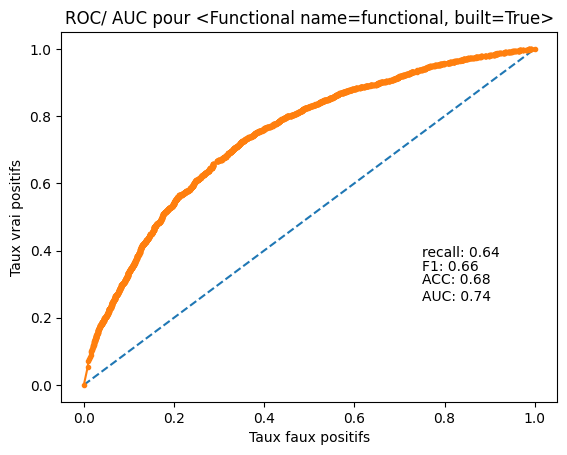

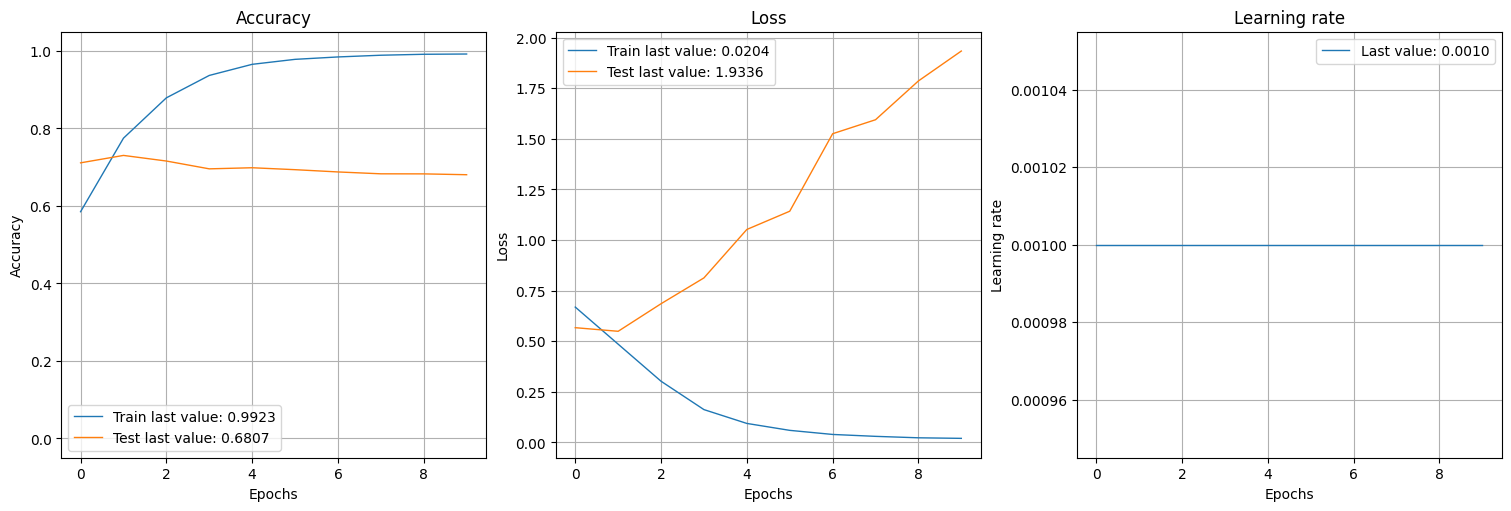

In [33]:
with mlflow.start_run(run_name='lstm_embedding'):



    sequence_input = Input(shape=(max_length,), dtype='int32')

    x = Embedding(vocab_size, embed_dim, input_length=max_length)(sequence_input)
    x = SpatialDropout1D(0.2)(x)
    x = Conv1D(64, 5, activation='relu')(x)
    x = Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2))(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)

    outputs = Dense(1, activation='sigmoid')(x)
    model = tf.keras.Model(sequence_input, outputs)

    # Compiler le modèle
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    # Afficher le résumé du modèle
    model.summary()
    #
    time1 = time.time()

    history = model.fit(X_train,
                        y_train,epochs=10,
                        batch_size=512,
                        validation_data=(X_test, y_test),
                        verbose=1,callbacks=callbacks_list)

    time2 = np.round(time.time() - time1,0)
    print("temps traitement : ", time2)

    # Evaluation du modèle
    plotRocAuc2(model, X_test, y_test)

    from plot_keras_history import show_history, plot_history

    show_history(history)
    plot_history(history, path="standard.png")
    plt.close()


## LSTM | Glove embedding

---

https://www.kaggle.com/code/endofnight17j03/nlp-beginner-text-classification-lstm#Word-Emdedding

In [34]:
!wget  --no-check-certificate http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2024-08-12 14:50:45--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2024-08-12 14:50:45--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2024-08-12 14:50:45--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [35]:
GLOVE_EMB = '/content/glove.6B.300d.txt'

In [36]:
embeddings_index = {}

f = open(GLOVE_EMB)
for line in f:
  values = line.split()
  word = value = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' %len(embeddings_index))

Found 400000 word vectors.


In [37]:
word_index=tokenizer_lstm.word_index

In [38]:
embedding_matrix = np.zeros((vocab_size, embed_dim))
for word, i in word_index.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector

**Entraînement du modèle**

---

In [39]:
mlflow.set_experiment('projet07avance')
mlflow.tensorflow.autolog()

2024/08/12 14:54:27 INFO mlflow.tracking.fluent: Experiment with name 'projet07avance' does not exist. Creating a new experiment.


In [47]:
#Définition de la liste de paramètres à tester
lstm_units_options = [128]
batch_size = [512]

In [41]:
embed_dim = 300

In [42]:
vocab_size,embed_dim

(30225, 300)

In [43]:
X_val.shape

(4800, 30)

In [44]:
max_length

30

In [45]:
X_train.shape,y_train.shape

((19200, 30), (19200,))

lstm_units :  128
batch_size :  512


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 19s 100ms/step - accuracy: 0.5697 - loss: 0.6757 - val_accuracy: 0.6858 - val_loss: 0.6005 - learning_rate: 0.0010
Epoch 2/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 87ms/step - accuracy: 0.6852 - loss: 0.5967 - val_accuracy: 0.7008 - val_loss: 0.5716 - learning_rate: 0.0010
Epoch 3/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 0.7168 - loss: 0.5635 - val_accuracy: 0.7050 - val_loss: 0.5607 - learning_rate: 0.0010
Epoch 4/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 7s 178ms/step - accuracy: 0.7266 - loss: 0.5426 - val_accuracy: 0.7098 - val_loss: 0.5553 - learning_rate: 0.0010
Epoch 5/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - accuracy: 0.7459 - loss: 0.5224 - val_accuracy: 0.7154 - val_loss: 0.5522 - learning_rate: 0.0010
Epoch 6/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 89ms/step - accuracy: 0.7664 - loss: 0.5010 - val_accuracy: 0.7127 - val_loss: 0.5487 - learning_rate: 0.0010
Epoch 7/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 7s 143ms/step - accuracy: 0.7798 - loss: 0.4692 - v

2024/08/12 14:57:59 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during tensorflow autologging: Changing param values is not allowed. Param with key='batch_size' was already logged with value='[512]' for run ID='75dbc4256fc94b3ea2a81000c7810049'. Attempted logging new value '512'.


temps traitement :  79.0
150/150 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step


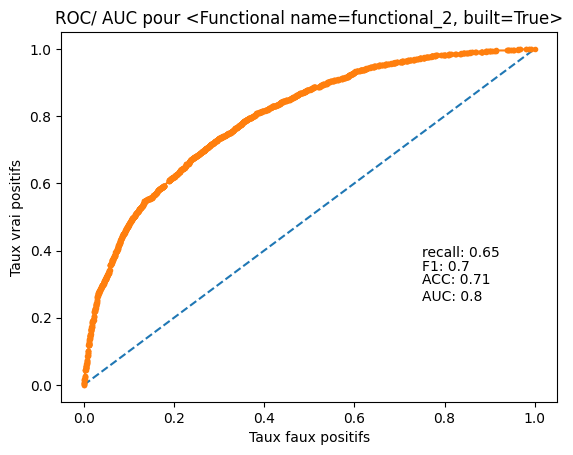

150/150 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step
AUC :  0.7973954748067483
188/188 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.7261 - loss: 0.5743
188/188 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - accuracy: 0.7261 - loss: 0.5743


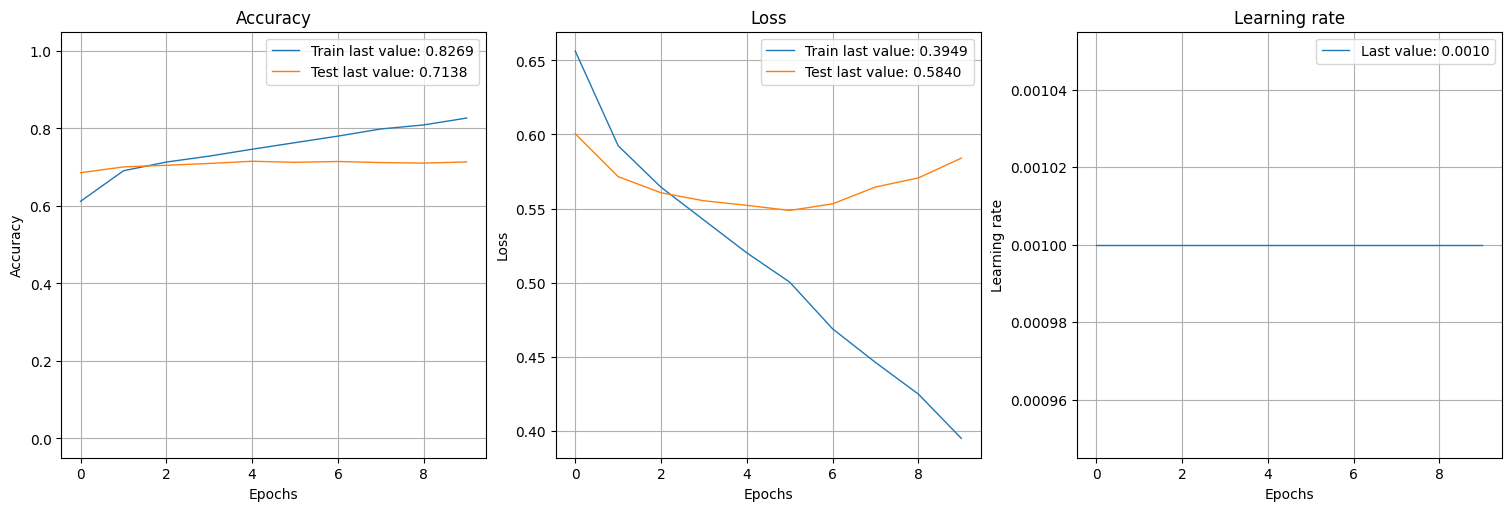

In [48]:
df_summary = pd.DataFrame(columns=['lstm_units', 'batch_size', 'time', 'accuracy', 'val_loss', 'auc'])
result_list = []

for lstm_units in lstm_units_options:
    for b in batch_size:

        print("lstm_units : ", lstm_units)
        print("batch_size : ", b)


        with mlflow.start_run(run_name = f"run{lstm_units,b}"):
            mlflow.log_param("embedding_dim", embed_dim)
            mlflow.log_param("lstm_units", lstm_units)
            mlflow.log_param("batch_size",batch_size)

            # création de la couche d' "embedding"
            embedding_layer = tf.keras.layers.Embedding(vocab_size,
                                        embed_dim,
                                        weights=[embedding_matrix],
                                        input_length=max_length,
                                        trainable=False)


            sequence_input = Input(shape=(max_length,), dtype='int32')

            embedding_sequences = embedding_layer(sequence_input)

            x = SpatialDropout1D(0.2)(embedding_sequences)
            x = Conv1D(64, 5, activation='relu')(x)
            x = Bidirectional(LSTM(units=lstm_units,
                            return_sequences=True,
                            kernel_initializer='glorot_uniform',
                            recurrent_initializer='orthogonal',
                            bias_initializer='zeros',
                            dropout=0.2,
                            recurrent_dropout=0.2,
                            unroll=False))(x)
            x = GlobalAveragePooling1D()(x)
            x = Dense(128, activation='relu')(x)
            x = Dropout(0.5)(x)
            x = Dense(128, activation='relu')(x)

            outputs = Dense(1, activation='sigmoid')(x)
            model2 = tf.keras.Model(sequence_input, outputs)


            model2.compile(optimizer= "adam", loss='binary_crossentropy',
                    metrics=['accuracy'])

            time1 = time.time()

            history2 = model2.fit(X_train, y_train, epochs=10, batch_size=b,
                            validation_data=(X_val, y_val), callbacks=callbacks_list)

            time2 = np.round(time.time() - time1,0)
            print("temps traitement : ", time2)

            model2.save('/content/drive/MyDrive/Colab Notebooks/PROJET07/model_lstm_glove.h5')

            plotRocAuc2(model2, X_val, y_val)

            auc= roc_auc_score(y_val, model2.predict(X_val))
            print("AUC : ", auc)

            # on définit la liste des métriques pour mlflow
            mlflow.log_metric("time", time2)
            mlflow.log_metric("val_loss", history2.history['val_loss'][-1])
            mlflow.log_metric("acc", history2.history['accuracy'][-1])
            mlflow.log_metric("test_loss", history2.history['loss'][-1])
            mlflow.log_metric("val_acc", history2.history['val_accuracy'][-1])

            mlflow.log_metric('accuray_test',model2.evaluate(X_test,y_test)[1])


            mlflow.log_metric("AUC", auc)

            result_dict = {
                'lstm_units': lstm_units,
                'batch_size': b,
                'time': time2,
                'accuracy': history2.history['accuracy'][-1],
                'val_loss': history2.history['val_loss'][-1],
                'loss': history2.history['loss'][-1],
                'val_acc': history2.history['val_accuracy'][-1],
                'test_acc': model2.evaluate(X_test,y_test)[1],
                'auc': auc
            }

            # Ajout du dictionnaire à la liste
            result_list.append(result_dict)

            # Concaténation des dictionnaires dans un DataFrame
            df_summary = pd.DataFrame(result_list)

            # Evaluation du modèle
            show_history(history2)


In [49]:
model2.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 30)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_2 (Embedding)              │ (None, 30, 300)             │       9,067,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout1d_2                  │ (None, 30, 300)             │               0 │
│ (SpatialDropout1D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 26, 64)              │          96,064 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ (None, 26, 256)             │         197,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_1           │ (None, 256)                 │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,097,201 (38.52 MB)

 Trainable params: 343,233 (1.31 MB)

 Non-trainable params: 9,067,500 (34.59 MB)

 Optimizer params: 686,468 (2.62 MB)

In [ ]:
df_summary

In [ ]:
model2.save('/content/sample_data/model02P07.h5')

## LSTM | Word2Vec

---

https://www.kaggle.com/code/rajmehra03/a-complete-text-classfication-guide-word2vec-lstm#A-Complete-Text-Classfication-Guide(Word2Vec+LSTM)

In [ ]:
import gensim

In [ ]:
# définition des hyperparamètres
w2v_size=300
w2v_window=10 #prends en considération les n mots avant et après
w2v_min_count=1 # nombre minimum de d'apparition d'un mot pour être pris en compte
w2v_epochs=100 # nombre de cycles d'entraînement


description_list = data['text_combined'].to_list()
sentences = [gensim.utils.simple_preprocess(text) for text in description_list]

In [ ]:
for i in sentences[:5]:
    print(i)

['finished', 'tv', 'section', 'added', 'section', 'hannah', 'montana', 'movie', 'go', 'look', 'corrie']
['themainecanada', 'success', 'still', 'failure']
['know', 'life', 'taking', 'better', 'wise', 'amp', 'take', 'quick']
['really', 'anything', 'say']
['buffytvsrox', 'posting', 'evil', 'want', 'wait', 'gone', 'sleep']


In [ ]:
max_length

30

In [ ]:
maxlen = max([len(i) for i in sentences])
maxlen

33

In [ ]:
print("Fit Tokenizer ...")
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)

#padding des séquences
X_sentences = pad_sequences(tokenizer.texts_to_sequences(sentences),
                                                     maxlen=maxlen,
                                                     padding='post')

num_words = len(tokenizer.word_index) + 1
print("Number of unique words: %i" % num_words)

Fit Tokenizer ...
Number of unique words: 33219


In [ ]:
print("Build & train Word2Vec model ...")

#instanciation du modèle
w2v_model = gensim.models.Word2Vec(min_count=w2v_min_count, window=w2v_window,
                                                vector_size=w2v_size,epochs=w2v_epochs)

# construction des features(vocabulaire)
w2v_model.build_vocab(sentences)

# entraînement du modèle
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=w2v_epochs)

model_vectors = w2v_model.wv  # wv= word vector

# génération du vocabulaire
w2v_words = model_vectors.index_to_key

print("Vocabulary size: %i" % len(w2v_words))
print("Word2Vec trained")

Build & train Word2Vec model ...
Vocabulary size: 33218
Word2Vec trained


In [ ]:
w2v_model.wv.most_similar('pizza')

[('lonchera', 0.46688228845596313),
 ('lillians', 0.39848849177360535),
 ('yummy', 0.3892543315887451),
 ('taco', 0.3743699789047241),
 ('tart', 0.37390899658203125),
 ('tomato', 0.371158242225647),
 ('oreo', 0.35355454683303833),
 ('theskorpion', 0.34994134306907654),
 ('yummo', 0.3477182686328888),
 ('stuffing', 0.33895614743232727)]

In [ ]:
num_words,vocab_size

(33219, 30183)

In [ ]:
# Création de la matrice d'embedding

print("Create Embedding matrix ...")

word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
embedding_matrix = np.zeros((num_words, w2v_size))
i=0
j=0

for word, idx in word_index.items():
    i +=1
    if word in w2v_words:
        j +=1
        embedding_vector = model_vectors[word]
        if embedding_vector is not None:
            embedding_matrix[idx] = model_vectors[word]

word_rate = np.round(j/i,4)
print("Word embedding rate : ", word_rate)
print("Embedding matrix: %s" % str(embedding_matrix.shape))

Create Embedding matrix ...
Word embedding rate :  1.0
Embedding matrix: (33219, 300)


In [ ]:
X_train_w2v,X_test_w2v,y_train_w2v,y_test_w2v=train_test_split(X_sentences,data['sentiment'],test_size=0.20,random_state=2)

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 33)]              0         
                                                                 
 embedding_6 (Embedding)     (None, 33, 300)           9965700   
                                                                 
 spatial_dropout1d_6 (Spati  (None, 33, 300)           0         
 alDropout1D)                                                    
                                                                 
 conv1d_6 (Conv1D)           (None, 29, 64)            96064     
                                                                 
 bidirectional_6 (Bidirecti  (None, 256)               197632    
 onal)                                                           
                                                                 
 dense_17 (Dense)            (None, 32)                8224

2024/07/05 08:00:29 WARNING mlflow.tensorflow: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'


Epoch 1/10
47/47 [==============================] - 26s 393ms/step - loss: 0.6253 - accuracy: 0.6536 - val_loss: 0.5646 - val_accuracy: 0.7170 - lr: 0.0010


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/10
47/47 [==============================] - 9s 195ms/step - loss: 0.5559 - accuracy: 0.7207 - val_loss: 0.5570 - val_accuracy: 0.7178 - lr: 0.0010
Epoch 3/10
47/47 [==============================] - 17s 370ms/step - loss: 0.5350 - accuracy: 0.7336 - val_loss: 0.5404 - val_accuracy: 0.7290 - lr: 0.0010
Epoch 4/10
47/47 [==============================] - 9s 188ms/step - loss: 0.5159 - accuracy: 0.7490 - val_loss: 0.5368 - val_accuracy: 0.7268 - lr: 0.0010
Epoch 5/10
47/47 [==============================] - 17s 368ms/step - loss: 0.4981 - accuracy: 0.7577 - val_loss: 0.5439 - val_accuracy: 0.7177 - lr: 0.0010
Epoch 6/10
47/47 [==============================] - 9s 183ms/step - loss: 0.4770 - accuracy: 0.7683 - val_loss: 0.5456 - val_accuracy: 0.7282 - lr: 0.0010
Epoch 7/10
47/47 [==============================] - 17s 360ms/step - loss: 0.4587 - accuracy: 0.7818 - val_loss: 0.5489 - val_accuracy: 0.7245 - lr: 0.0010
Epoch 8/10
47/47 [==============================] - 9s 184ms/step -

2024/07/05 08:03:20 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.10/dist-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils."
/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


temps traitement :  171.0
188/188 [==============================] - 6s 30ms/step


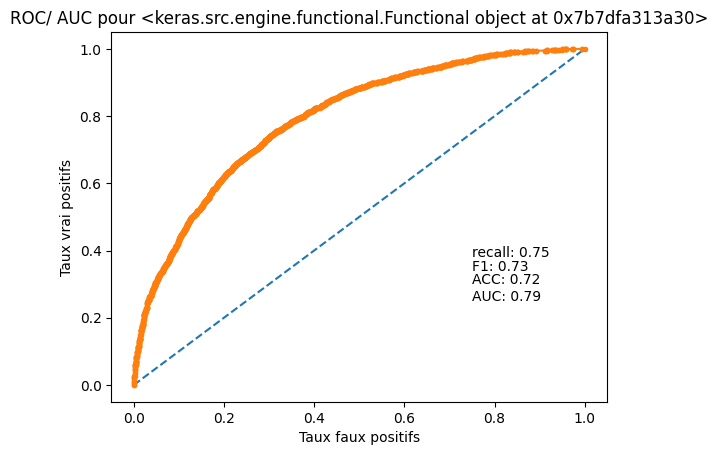

In [ ]:

with mlflow.start_run(run_name='lstm_w2vec'):
    input=Input(shape=(len(X_sentences),maxlen),dtype='float64')

    word_input=Input(shape=(maxlen,),dtype='float64')

    word_embedding=Embedding(input_dim=num_words,
                            output_dim=w2v_size,
                            weights = [embedding_matrix],trainable=False)(word_input)

    x = SpatialDropout1D(0.2)(word_embedding)
    x = Conv1D(64, 5, activation='relu')(x)
    x = Bidirectional(LSTM(128, dropout=0.2, recurrent_dropout=0.2))(x)
    x = Dense(32, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(16, activation='relu')(x)

    word_vec=Dense(1,activation='sigmoid')(x)
    model4 = Model([word_input],word_vec)

    model4.summary()

    model4.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    time1 = time.time()

    history4 = model4.fit(X_train_w2v, y_train_w2v, epochs=10, batch_size=512,
                    validation_data=(X_test_w2v, y_test_w2v), callbacks=callbacks_list)
    time2 = np.round(time.time() - time1,0)

    model4.save('/content/drive/MyDrive/Colab Notebooks/PROJET07/model_lstm_w2vec.h5')

    print("temps traitement : ", time2)
    plotRocAuc2(model4, X_test_w2v, y_test_w2v)

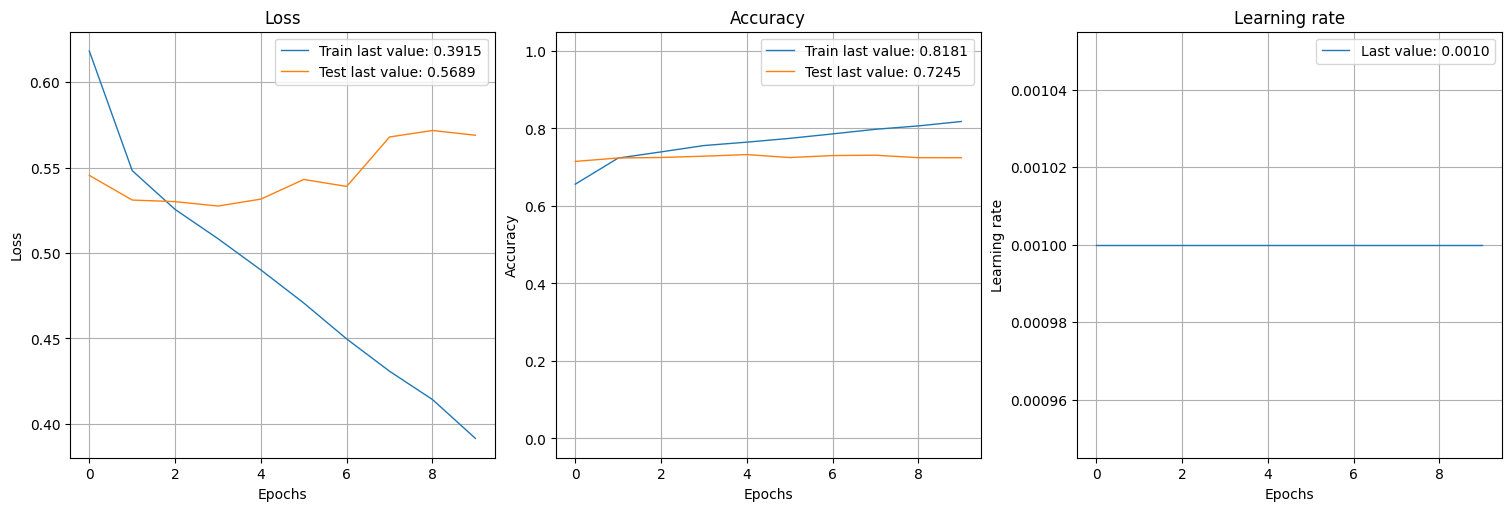

In [ ]:
from plot_keras_history import show_history, plot_history
import matplotlib.pyplot as plt

show_history(history4)
plot_history(history4, path="standard.png")
plt.close()

# Classification Deep Learning : BERT

Nous utiliserons comme modèle de NLP "DistilBERT" qui est une version allégée de BERT

## Preprocessing pour BERT

In [ ]:
mlflow.pytorch.autolog()

2024/07/05 08:13:33 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of pytorch. If you encounter errors during autologging, try upgrading / downgrading pytorch to a supported version, or try upgrading MLflow.


**Séparation du jeu de donnée en entraînement/test**


---



In [ ]:
X_dl = data['text_dl']
y_dl = data['sentiment']

X_dl_train, X_dl_test, y_dl_train, y_dl_test = train_test_split(X_dl, y_dl, test_size=0.2, random_state=2)

train_df = pd.DataFrame({'text': X_dl_train, 'label': y_dl_train})
test_df = pd.DataFrame({'text': X_dl_test, 'label': y_dl_test})

**Converstion des jeux d'entraînement/test en Dataset**

---

In [ ]:
!pip install datasets --quiet
!pip install transformers==4.17 --quiet
!pip install accelerate -U --quiet


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 19.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 16.1.0 which is incompatible.
google-colab 1.0.0 requires requests==2.31.0, but you have requests 2.32.3 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 16.1.0 which is incompatible.
mlflow 2.14.2 requires pyarrow<16,

In [ ]:
!pip uninstall pyarrow
!pip install pyarrow

Found existing installation: pyarrow 16.1.0
Uninstalling pyarrow-16.1.0:
  Would remove:
    /usr/local/lib/python3.10/dist-packages/pyarrow-16.1.0.dist-info/*
    /usr/local/lib/python3.10/dist-packages/pyarrow/*
Proceed (Y/n)? y
  Successfully uninstalled pyarrow-16.1.0
  Using cached pyarrow-16.1.0-cp310-cp310-manylinux_2_28_x86_64.whl (40.8 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 16.1.0 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 16.1.0 which is incompatible.
mlflow 2.14.2 requires pyarrow<16,>=4.0.0, but you have pyarrow 16.1.0 which is incompatible.


In [ ]:
from datasets import Dataset

In [ ]:


train_dataset = Dataset.from_pandas(train_df,split = 'train')
test_dataset = Dataset.from_pandas(test_df,split = 'test')

In [ ]:
train_dataset['text'][12:22]

['happy mothers day',
 'oh my a friend informed me that the major fast food brands have made their way to san sebastian i can t express how sad that is sigh',
 'hates that she has to work when all she wants to do is sleep and be with her family i need my friends',
 'misskellyo mornin although it s late afternoon in a real time zone',
 'i love gettin spoiled its freakiin awesome',
 'rewindandfreeze im so sorry im ironing my hair ksi haha',
 'bnookala my siblings are unreasonable',
 'dinner hw mtv awards new moon trailer',
 'my car wont catch up guys americana',
 'is so tired right now and still wishes he was at so bad me wanna hang out with all the booth babes and left for dead to would be cool']

**Tokenisation**

---



In [ ]:
def compute_metrics(p):
    preds = p.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(p.label_ids, preds, average='binary')
    acc = accuracy_score(p.label_ids, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }


In [ ]:
def tokenize_text(example):
    return tokenizer(example['text'], padding=True, truncation=True)

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')

Downloading:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

In [ ]:
tokenize_text(train_dataset[4])

{'input_ids': [101, 2026, 2606, 2003, 1037, 7071, 1045, 2074, 3651, 2008, 1045, 1049, 2025, 2590, 2438, 2005, 1037, 10474, 3931, 20934, 4183, 2040, 14977, 2821, 2196, 23356, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [ ]:
train_tokenized = train_dataset.map(tokenize_text, batched=True)
test_tokenized = test_dataset.map(tokenize_text, batched=True)

Map:   0%|          | 0/24000 [00:00<?, ? examples/s]

Map:   0%|          | 0/6000 [00:00<?, ? examples/s]

In [ ]:
train_tokenized.column_names

['text', 'label', '__index_level_0__', 'input_ids', 'attention_mask']

**Construction du modèle**

---

In [ ]:

with mlflow.start_run(run_name='bert'):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    bert_model = AutoModelForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2).to(device)
    from transformers import DataCollatorWithPadding
    # Creating a data collator that will dynamically pad the inputs received:
    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
    # debbug trainer https://discuss.huggingface.co/t/trainingargument-does-not-work-on-colab/43372/5
    training_args = TrainingArguments(
        output_dir="distilbert-emotion",
        learning_rate=2e-5,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        num_train_epochs=2,
        report_to="none",)


    trainer = Trainer(
        model=bert_model,
        args=training_args,
        train_dataset=train_tokenized,
        eval_dataset=test_tokenized,
        compute_metrics=compute_metrics,
        data_collator=DataCollatorWithPadding(tokenizer),)

    time1 = time.time()
    trainer.train()
    time2 = np.round(time.time() - time1,0)
    print("temps traitement : ", time2)

    Bert_scores = trainer.evaluate()
    mlflow.log_metrics(Bert_scores)

Downloading:   0%|          | 0.00/256M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.weight', 'classifier

Step,Training Loss
500,0.507000
1000,0.464100
1500,0.466800
2000,0.438400
2500,0.439100
3000,0.434500
3500,0.335900
4000,0.345100
4500,0.342100
5000,0.346400


Saving model checkpoint to distilbert-emotion/checkpoint-500
Configuration saved in distilbert-emotion/checkpoint-500/config.json
Model weights saved in distilbert-emotion/checkpoint-500/pytorch_model.bin
Saving model checkpoint to distilbert-emotion/checkpoint-1000
Configuration saved in distilbert-emotion/checkpoint-1000/config.json
Model weights saved in distilbert-emotion/checkpoint-1000/pytorch_model.bin
Saving model checkpoint to distilbert-emotion/checkpoint-1500
Configuration saved in distilbert-emotion/checkpoint-1500/config.json
Model weights saved in distilbert-emotion/checkpoint-1500/pytorch_model.bin
Saving model checkpoint to distilbert-emotion/checkpoint-2000
Configuration saved in distilbert-emotion/checkpoint-2000/config.json
Model weights saved in distilbert-emotion/checkpoint-2000/pytorch_model.bin
Saving model checkpoint to distilbert-emotion/checkpoint-2500
Configuration saved in distilbert-emotion/checkpoint-2500/config.json
Model weights saved in distilbert-emoti

temps traitement :  539.0


The following columns in the test set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 6000
  Batch size = 8


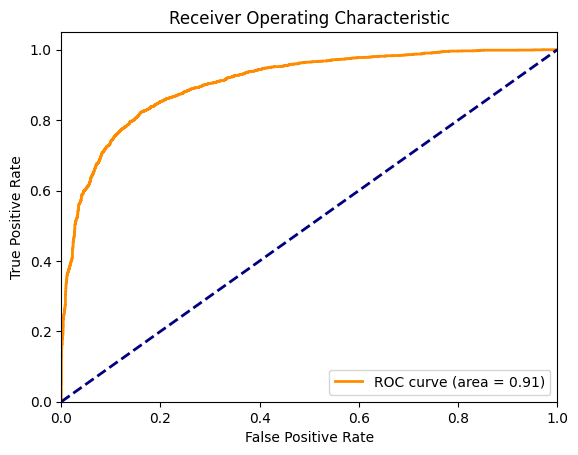

In [ ]:

import torch.nn.functional as F
from sklearn.metrics import roc_curve, auc

def plotRocAuc3(trainer, X, y):
    # Get predictions from the Trainer
    predictions = trainer.predict(X)

    # Extract logits and compute probabilities
    logits = predictions.predictions
    probabilities = F.softmax(torch.tensor(logits), dim=1)[:, 1]  # keep probabilities for the positive class

    # Compute ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(y, probabilities)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

# Call the function with your Trainer and test data
plotRocAuc3(trainer, test_tokenized, y_dl_test)

**Evaluation du modèle**

---

In [ ]:
print(f"Accuracy: {Bert_scores['eval_accuracy']}")
print(f"F1 Score: {Bert_scores['eval_f1']}")
print(f"Precision: {Bert_scores['eval_precision']}")
print(f"Recall: {Bert_scores['eval_recall']}")

Accuracy: 0.8298333333333333
F1 Score: 0.8299183741462602
Precision: 0.8361866398120175
Recall: 0.8237433862433863


https://medium.com/analytics-vidhya/how-to-use-google-colab-with-github-via-google-drive-68efb23a42d

# Classification Deep Learning : USE

In [ ]:
import tensorflow_hub as hub

embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [ ]:
# Fonction pour encoder les textes
def embed_texts(texts):
    embeddings = embed(texts)
    return np.array(embeddings)

# Encoder les textes d'entraînement et de test
X_train_embedded = embed_texts(train_dataset['text'])
X_test_embedded = embed_texts(test_dataset['text'])
y_train = train_dataset['label']
y_test = test_dataset['label']


In [ ]:
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# Convertir les données en tenseurs PyTorch
X_train_tensor = torch.tensor(X_train_embedded, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_embedded, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Créer des DataLoaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
import torch.nn as nn

In [ ]:
class SentimentClassifier(nn.Module):
    def __init__(self, input_dim):
        super(SentimentClassifier, self).__init__()
        self.fc = nn.Linear(input_dim, 2)

    def forward(self, x):
        return self.fc(x)

model = SentimentClassifier(input_dim=512)

In [ ]:
training_args = TrainingArguments(
        output_dir="distilbert-emotion",
        learning_rate=2e-5,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        num_train_epochs=2,
        report_to="none",)


time1 = time.time()
trainer = Trainer(
    model=bert_model,
    args=training_args,
    train_dataset=train_tokenized,
    eval_dataset=test_tokenized,
    compute_metrics=compute_metrics,
    data_collator=DataCollatorWithPadding(tokenizer),)

time1 = time.time()
trainer.train()
time2 = np.round(time.time() - time1,0)
print("temps traitement : ", time2)


USE_scores = trainer.evaluate()

PyTorch: setting up devices
The following columns in the training set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 24000
  Num Epochs = 2
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 6000


Step,Training Loss
500,0.253900
1000,0.242400
1500,0.275400
2000,0.248900
2500,0.243000
3000,0.268800
3500,0.122300
4000,0.142500
4500,0.158600
5000,0.196900


Saving model checkpoint to distilbert-emotion/checkpoint-500
Configuration saved in distilbert-emotion/checkpoint-500/config.json
Model weights saved in distilbert-emotion/checkpoint-500/pytorch_model.bin
Saving model checkpoint to distilbert-emotion/checkpoint-1000
Configuration saved in distilbert-emotion/checkpoint-1000/config.json
Model weights saved in distilbert-emotion/checkpoint-1000/pytorch_model.bin
Saving model checkpoint to distilbert-emotion/checkpoint-1500
Configuration saved in distilbert-emotion/checkpoint-1500/config.json
Model weights saved in distilbert-emotion/checkpoint-1500/pytorch_model.bin
Saving model checkpoint to distilbert-emotion/checkpoint-2000
Configuration saved in distilbert-emotion/checkpoint-2000/config.json
Model weights saved in distilbert-emotion/checkpoint-2000/pytorch_model.bin
Saving model checkpoint to distilbert-emotion/checkpoint-2500
Configuration saved in distilbert-emotion/checkpoint-2500/config.json
Model weights saved in distilbert-emoti

temps traitement :  536.0


In [ ]:

trainer.compute_metrics = compute_metrics


The following columns in the test set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 6000
  Batch size = 8


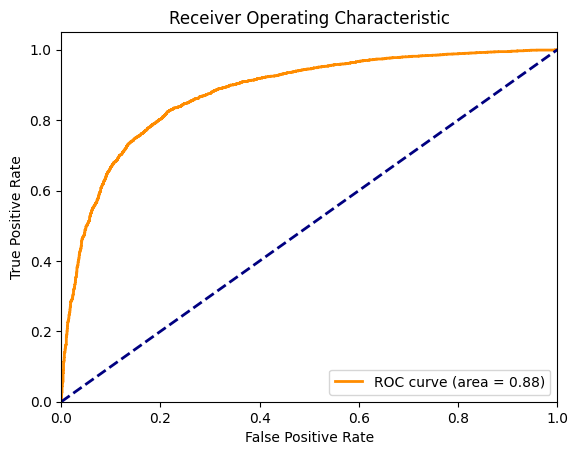

In [ ]:
plotRocAuc(trainer, test_tokenized, y_dl_test)

In [ ]:
trainer.evaluate()['']

In [ ]:
print(f"Accuracy: {USE_scores['eval_accuracy']}")
print(f"F1 Score: {USE_scores['eval_f1']}")
print(f"Precision: {USE_scores['eval_precision']}")
print(f"Recall: {USE_scores['eval_recall']}")

Accuracy: 0.8016666666666666
F1 Score: 0.7990543735224586
Precision: 0.7966329966329966
Recall: 0.801490514905149
